<a href="https://colab.research.google.com/github/Mario-RJunior/diagnostico-medico-raio-x/blob/main/departamento_medico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Departamento médico

## Importação das bibliotecas e base de dados

In [1]:
# Importado as bibliotecas
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Acessando os arquivos pelo Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Criando o caminho até as imagens
xray_directory = '/content/drive/My Drive/Departamento médico/Dataset/'

In [4]:
# Verificando a presença das imagens no caminho acima
os.listdir(xray_directory)

['.DS_Store', '0', '3', '1', '2']

In [5]:
# Acessando as imagens
image_generator = ImageDataGenerator(rescale=1./225)

In [6]:
# Buscando as imagens de treinamento
train_generator = image_generator.flow_from_directory(batch_size=40,
                                                      directory=xray_directory,
                                                      shuffle=True,
                                                      target_size=(256,256),
                                                      class_mode='categorical',
                                                      subset='training')

Found 532 images belonging to 4 classes.


In [7]:
# Variáveis para teste
train_images, train_labels = next(train_generator)

In [ ]:
train_images.shape

(40, 256, 256, 3)

In [ ]:
# Mostrando cada uma das classes
train_labels

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]],

Note que temos 4 classes e portanto nossa rede neural terá 4 neurônios na camada de saída.

In [8]:
# Identificando os labels (funciona como variável dummy)
label_names = {0: 'Covid-19', 1: 'Normais', 2: 'Pneumonia viral', 3: 'Pneumonia bacterial'}

## Visualização dos dados

Queremos inicialmente listar as imagens carrgando-as diretamente do Google Colab.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

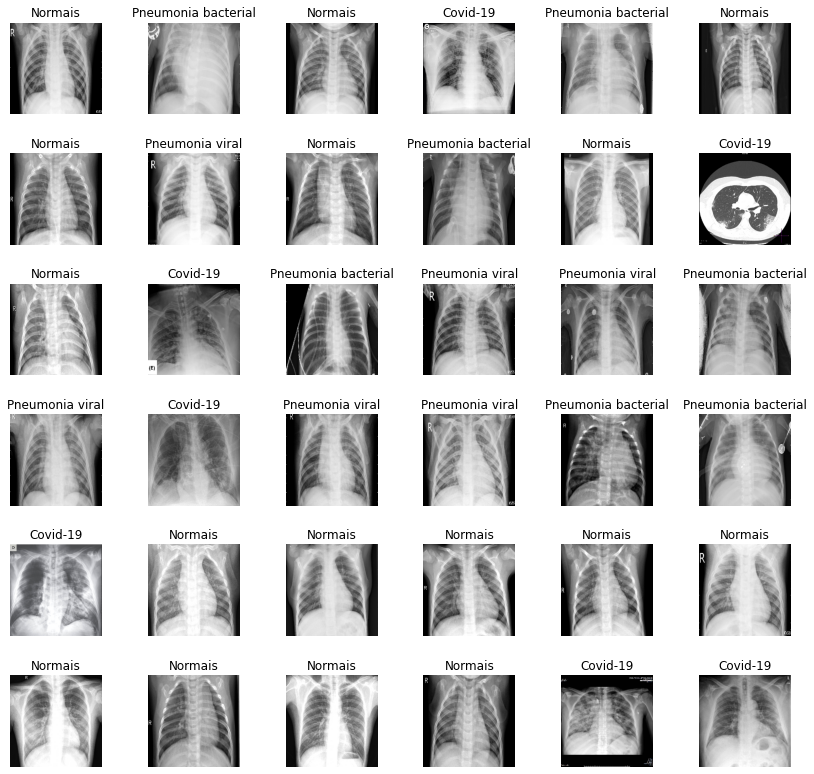

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(14,14))
axes = axes.ravel()  # Transforma uma matriz em um vetor

for i in np.arange(0,36):
  axes[i].imshow(train_images[i])
  axes[i].set_title(label_names[np.argmax(train_labels[i])])
  axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

## Carregamento da rede neural com pesos pré-treinados

In [9]:
# Criando um modelo base
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_tensor=Input(shape=(256,256,3)))

94773248/94765736 [==============================] - 1s 0us/step


Fizemos então o carregamento do modelo base que usaremos para treinar nossas imagens relacionadas às doenças pulmonares. Veremos então as camadas do modelo.

In [10]:
# Camadas do base model
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Este resultado acima mostra a arquitetura da ResNet que já está totalmente definida.

In [11]:
# Verificando a quantidade de camadas
len(base_model.layers)

175

Como iremos utilizar uma rede neural ja previamente treinada, precisamos aproveitar os pesos já obtidos por ela para usá-los no nosso modelo. Para isso, faremos o seguinte código:

In [12]:
# Congelando os pesos (exceto das 10 últimas camadas)
for layer in base_model.layers[:-10]:
  layers.treinable = False # "Congela" os pesos para estes não serem treinados novamente

## Construção e treinamento do modelo de Deep Learning

De posse do modelo base construido na seção anterior, iremos aplicá-lo agora no nosso modelo.

In [13]:
# Criando o cabeçalho da nossa rede neural
head_model = base_model.output
head_model = AveragePooling2D()(head_model)
head_model = Flatten()(head_model)
head_model = Dense(256, activation='relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(256, activation='relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(4, activation='softmax')(head_model)

In [14]:
# Criando o modelo
model = Model(inputs=base_model.input, outputs=head_model)

In [15]:
# Compilando a rede neural
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-4, 
                                           decay=1e-6), 
              metrics=['accuracy'])

In [16]:
# Fazendo o treinamento da rede neural
checkpointer = ModelCheckpoint(filepath='weights.hdf5')

Precisamos ainda redefinir a variável train_generator para batch_size = 4. Isto faz com que o ajuste dos pesos seja feito de 4 em 4 imagens.

In [17]:
# Redefinindo a variável train_generator
train_generator = image_generator.flow_from_directory(batch_size=4,
                                                      directory=xray_directory,
                                                      shuffle=True,
                                                      target_size=(256,256),
                                                      class_mode='categorical',
                                                      subset='training')

Found 532 images belonging to 4 classes.


In [ ]:
# Histórico do treinamento
history = model.fit_generator(train_generator, epochs=25, callbacks=[checkpointer])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
133/133 [==============================] - 510s 4s/step - loss: 1.3369 - accuracy: 0.6466
Epoch 2/25
133/133 [==============================] - 484s 4s/step - loss: 0.5287 - accuracy: 0.8418
Epoch 3/25
133/133 [==============================] - 484s 4s/step - loss: 0.3391 - accuracy: 0.9071
Epoch 4/25
133/133 [==============================] - 500s 4s/step - loss: 0.2989 - accuracy: 0.9447
Epoch 5/25
133/133 [==============================] - 488s 4s/step - loss: 0.2770 - accuracy: 0.9655
Epoch 6/25
133/133 [==============================] - 486s 4s/step - loss: 0.1820 - accuracy: 0.9746
Epoch 7/25
133/133 [==============================] - 484s 4s/step - loss: 0.0245 - accuracy: 0.9969
Epoch 8/25
133/133 [==============================] - 485s 4s/step - loss: 0.2258 - accuracy: 0.9790
Epoch 9/25
133/133 [==============================] - 495s 4s/step - loss: 0.2494 - accuracy: 0.9711
Epoch 10/25
133/133 [==============================] - 486s 4s/step - loss: 0.1328 - accura

In [18]:
model.fit_generator(train_generator, epochs=25, callbacks=[checkpointer])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
133/133 [==============================] - 582s 4s/step - loss: 1.3711 - accuracy: 0.6386
Epoch 2/25
133/133 [==============================] - 548s 4s/step - loss: 0.5209 - accuracy: 0.8769
Epoch 3/25
133/133 [==============================] - 553s 4s/step - loss: 0.3853 - accuracy: 0.8869
Epoch 4/25
133/133 [==============================] - 536s 4s/step - loss: 0.2173 - accuracy: 0.9361
Epoch 5/25
133/133 [==============================] - 544s 4s/step - loss: 0.1618 - accuracy: 0.9666
Epoch 6/25
133/133 [==============================] - 527s 4s/step - loss: 0.1641 - accuracy: 0.9579
Epoch 7/25
133/133 [==============================] - 523s 4s/step - loss: 0.1804 - accuracy: 0.9513
Epoch 8/25
133/133 [==============================] - 523s 4s/step - loss: 0.1505 - accuracy: 0.9717
Epoch 9/25
133/133 [==============================] - 535s 4s/step - loss: 0.1627 - accuracy: 0.9771
Epoch 10/25
133/133 [==============================] - 522s 4s/step - loss: 0.0216 - accura

## Avaliação da rede neural

Feito o treinamento da rede neural iremos agora avaliar sua performance.

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

Plotando um gráfico do Accuracy, que é a taxa de acerto e do loss que é o erro do modelo na base de treinamento.

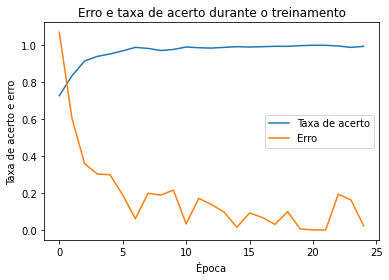

In [ ]:
# Plotando o accuracy e o loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Erro e taxa de acerto durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Taxa de acerto e erro')
plt.legend(['Taxa de acerto', 'Erro']);

Avaliando agora o modelo na base de testes.

In [19]:
# Criando variável com o caminho das imagens de teste
test_directory = '/content/drive/My Drive/Departamento médico/Test'

In [20]:
os.listdir(test_directory)

['2', '0', '3', '1']

In [21]:
# Pré processamento das imagens de teste
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size=40, 
                                              directory=test_directory, 
                                              shuffle=True,
                                              target_size=(256,256), 
                                              class_mode='categorical')

Found 40 images belonging to 4 classes.


In [ ]:
# Avaliação
evaluate = model.evaluate_generator(test_generator)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [ ]:
print('Erro: {} \nTaxa de acerto: {}'.format(evaluate[0], evaluate[1]))

Erro: 3.9265236854553223 
Taxa de acerto: 0.8500000238418579


Como visto acima, conseguimos uma acurácia de aproximadamente 85%. 

Podemos agora algumas previsões (com suas respostas corretas) e logo após gerar uma matriz de confusão para fazermos uma análise classe por classe.

In [ ]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory, str(i))):
    img = cv2.imread(os.path.join(test_directory, str(i), item))
    img = cv2.resize(img, (256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [ ]:
print(prediction)
print(original)

[0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 2, 1, 1, 2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


Podemos finalmente gerar as métricas utilizando a matriz de confusão.

In [ ]:
# Importando as bibliotecas
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
# Verificando o accuracy
accuracy_score(original, prediction)

0.825

Podemos gerar agora uma matriz de dados (com a lista original e a lista das previsões) para fazer uma comparação entre elas.

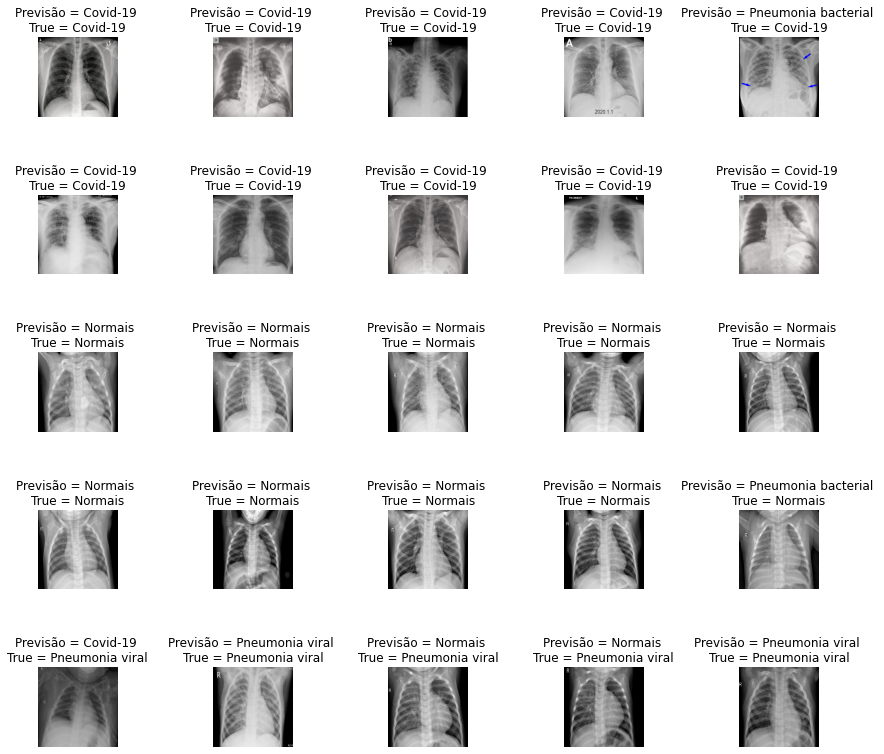

In [ ]:
# Gerando um gráfico das previsões
fig, axes = plt.subplots(5,5, figsize=(14,14))
axes = axes.ravel()
for i in np.arange(0, 25):
  axes[i].imshow(image[i])
  axes[i].set_title('Previsão = {} \nTrue = {}'.format(str(label_names[prediction[i]]),
                                                    str(label_names[original[i]])))
  axes[i].axis('off')
plt.subplots_adjust(wspace=1.2)

In [ ]:
label_names

{0: 'Covid-19', 1: 'Normais', 2: 'Pneumonia viral', 3: 'Pneumonia bacterial'}

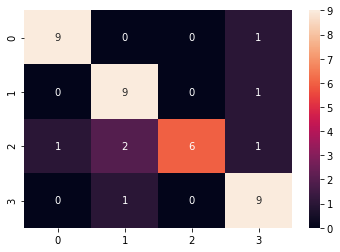

In [ ]:
# Matriz de confusão
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True);

In [ ]:
# Relatório de classificação
print(classification_report(original, prediction))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.75      0.90      0.82        10
           2       1.00      0.60      0.75        10
           3       0.75      0.90      0.82        10

    accuracy                           0.82        40
   macro avg       0.85      0.82      0.82        40
weighted avg       0.85      0.82      0.82        40



## Classificação de somente uma imagem

Esta parte final tem como intuito classificar apenas uma imagem, como se estivessemos com o modelo definido e colocando-o em produção.

Quando treinamos o modelo salvamos o classificador (arquivo weights.hdf5) e agora iremos carregá-lo e utilizá-lo para fazer uma previsão.

In [ ]:
# Importando a biblioteca para carregamento do modelo
from keras.models import load_model

# Carregando o modelo
model_loaded = load_model('/content/weights.hdf5')

In [ ]:
# Estrutura da rede neural
model_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
# Carregando agora uma imagem
img = cv2.imread('/content/drive/My Drive/Departamento médico/Test/0/nejmoa2001191_f4.jpeg')

In [ ]:
img, img.shape

(array([[[55, 52, 54],
         [55, 52, 54],
         [55, 52, 54],
         ...,
         [55, 52, 54],
         [55, 52, 54],
         [55, 52, 54]],
 
        [[55, 52, 54],
         [55, 52, 54],
         [55, 52, 54],
         ...,
         [55, 52, 54],
         [55, 52, 54],
         [55, 52, 54]],
 
        [[55, 52, 54],
         [55, 52, 54],
         [55, 52, 54],
         ...,
         [55, 52, 54],
         [55, 52, 54],
         [55, 52, 54]],
 
        ...,
 
        [[55, 52, 54],
         [55, 52, 54],
         [55, 52, 54],
         ...,
         [55, 52, 54],
         [55, 52, 54],
         [55, 52, 54]],
 
        [[55, 52, 54],
         [55, 52, 54],
         [55, 52, 54],
         ...,
         [55, 52, 54],
         [55, 52, 54],
         [55, 52, 54]],
 
        [[55, 52, 54],
         [55, 52, 54],
         [55, 52, 54],
         ...,
         [55, 52, 54],
         [55, 52, 54],
         [55, 52, 54]]], dtype=uint8), (1439, 1800, 3))

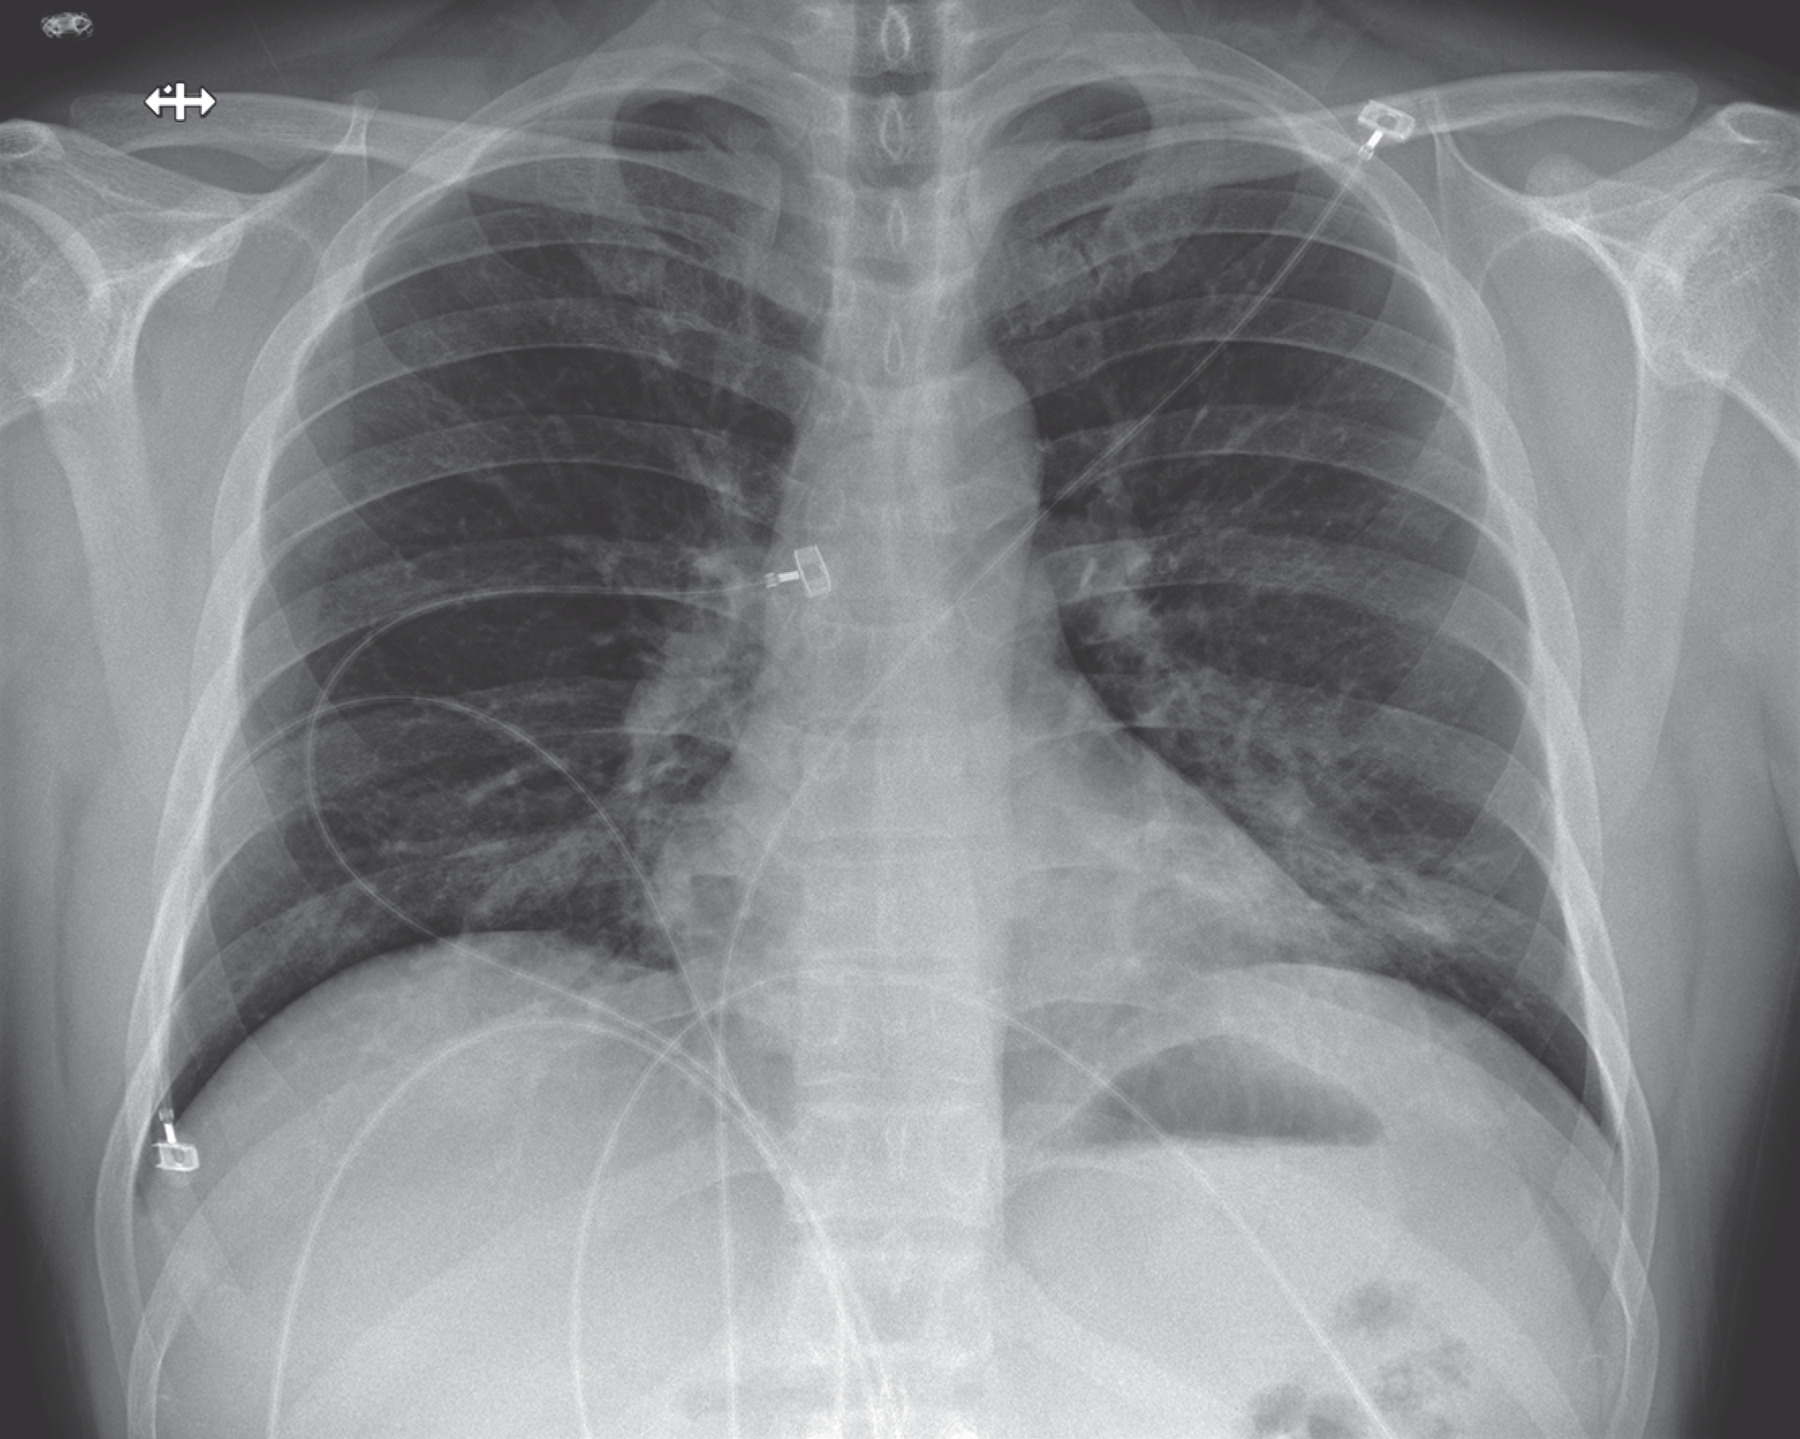

In [ ]:
# Importando a biblioteca
from google.colab.patches import cv2_imshow

# Visualizando a imagem original
cv2_imshow(img)

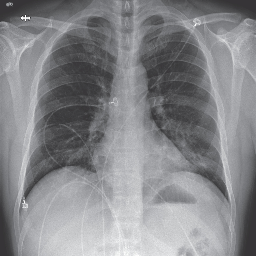

In [ ]:
# Redimensionando a imagem
img = cv2.resize(img, (256,256))
cv2_imshow(img)

In [ ]:
# Normalizando
img = img / 255
img

array([[[0.21568627, 0.20392157, 0.21176471],
        [0.21568627, 0.20392157, 0.21176471],
        [0.21568627, 0.20392157, 0.21176471],
        ...,
        [0.21568627, 0.20392157, 0.21176471],
        [0.21568627, 0.20392157, 0.21176471],
        [0.21568627, 0.20392157, 0.21176471]],

       [[0.21568627, 0.20392157, 0.21176471],
        [0.21568627, 0.20392157, 0.21176471],
        [0.21568627, 0.20392157, 0.21176471],
        ...,
        [0.21568627, 0.20392157, 0.21176471],
        [0.21568627, 0.20392157, 0.21176471],
        [0.21568627, 0.20392157, 0.21176471]],

       [[0.21568627, 0.20392157, 0.21176471],
        [0.21568627, 0.20392157, 0.21176471],
        [0.21568627, 0.20392157, 0.21176471],
        ...,
        [0.21568627, 0.20392157, 0.21176471],
        [0.21568627, 0.20392157, 0.21176471],
        [0.21568627, 0.20392157, 0.21176471]],

       ...,

       [[0.21568627, 0.20392157, 0.21176471],
        [0.21568627, 0.20392157, 0.21176471],
        [0.21568627, 0

In [ ]:
# Verificando o shape
img.shape

(256, 256, 3)

In [ ]:
# Redimensionando
img = img.reshape(-1, 256, 256 , 3)
img.shape

(1, 256, 256, 3)

In [ ]:
# Fazendo a previsão
predict = model_loaded(img)
predict[0]

<tf.Tensor: shape=(4,), dtype=float32, numpy=
array([1.0000000e+00, 7.7824757e-33, 8.8351234e-35, 5.3228563e-27],
      dtype=float32)>

In [ ]:
# Buscando o índice com o maior valor
predict2 = np.argmax(predict)
predict2

0

Vemos que o modelo previu a imagem como sendo da classe 0. Para sabermos o nome da classe, temos:

In [ ]:
# Verificando o nome da classe 0
label_names[predict2]

'Covid-19'

In [ ]:
# Verificando a porcentagem de certeza
label_names[predict2], predict[0][predict2]

('Covid-19', <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

Finalmente, vemos que a previsão feita acima foi para Covid-19 com percentual de 100% de certeza.

## Salvando o modelo - Outra forma

Salvaremos o modelo utilizando o tensorflow para utilizarmos posteriormente em um deploy para um aplicativo Android.

In [ ]:
# Salvando o modelo com TensorFlow Lite
x_ray_saved_model = 'saved_model'
tf.saved_model.save(model, x_ray_saved_model)
converter = tf.lite.TFLiteConverter.from_saved_model(x_ray_saved_model)
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: saved_model/assets


In [ ]:
# Gerando arquivo de texto com labels
labels = ['Covid-19', 'Normais', 'Pneumonia viral', 'Pneumonia bacterial']

with open('labels.txt', 'w') as f:
  f.write('\n'.join(labels))